In [7]:
import os
import sys
import errno
import re
import glob
import os.path as op
import json
from datetime import datetime, timedelta
from IPython.display import display, clear_output, HTML
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import osr, ogr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.gridspec as pltg
import seaborn as sn
from matplotlib.colors import LogNorm
import calendar
from pyproj import Proj, transform
import xml.etree.ElementTree as ET
import zipfile
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [8]:
def getDateFromStr(N):
    sepList = ["","-","_","/"]
    date = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
           date = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
           break
    return date

def getTimeFromStr(N,):
    sepList = ["","-","_"]
    HHMMSS = ''
    for s in sepList :
        found = re.search('-'+'\d{2}'+ s +'\d{2}'+ s +'\d{2}'+'-', N)
        if found != None :
            HHMMSS = datetime.strptime(found.group(0), '%H'+ s +'%M'+ s +'%S'+'_').time()
            break
    return HHMMSS

def reproject(inEPSG,outEPSG,x1,y1):
    
    inProj = Proj(init='EPSG:' + inEPSG)
    outProj = Proj(init='EPSG:'+ outEPSG)
    x2,y2 = transform(inProj,outProj,x1,y1)
    
    return x2, y2

def getCoords(G):
    
    
    GT = G.GetGeoTransform()
    minx = GT[0]
    maxy = GT[3]
    maxx = minx + GT[1] * G.RasterXSize
    miny = maxy + GT[5] * G.RasterYSize
    
    return minx, maxy, maxx, miny

def mkdir_p(dos):
    try:
        os.makedirs(dos)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(dos):
            pass
        else:
            raise
            
def getTileFromStr(N):

    tile = ''
    found = re.search('\d{2}' +'[A-Z]{3}', N)
    if found != None : tile = found.group(0)
    return tile



In [9]:
MAIN_path=f"/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/snow_code"
SWH_path = f"/home/ad/barrouz/datalake/theia/prod/SPOTWORLDHERITAGE"
PERF_PATH = op.join(MAIN_path,"performances")


SNOW_path =f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/ARTHUR_ALPS/OUTPUTS/UNET_SNOW"
LANDSAT_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR"
study_area_shp= f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/ARTHUR_ALPS/mtn_shp/arthur_t2k.shp"
LANDSAT_LIS_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR/ALP_LIS"
SNOW_LIS_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/ARTHUR_ALPS/OUTPUTS/UNET_SNOW_LIS"
LISTS_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/ARTHUR_ALPS/LISTS"
TCD_PATH="/datalake/static_aux/TreeCoverDensity"
DEM_PATH="/work/CAMPUS/etudes/Neige/DEM"
CONFIG_path=f"{MAIN_path}/configs"
driver = gdal.GetDriverByName('GTiff')

In [10]:
S2_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':600000,'MINY':4690200,'MAXX':709800,'MAXY':4800000},
        '30TYN':{'EPSG':'32630','MINX':699960,'MINY':4690200,'MAXX':809760,'MAXY':4800000},
        '31TCH':{'EPSG':'32631','MINX':300000,'MINY':4690200,'MAXX':409800,'MAXY':4800000},
        '31TDH':{'EPSG':'32631','MINX':399960,'MINY':4690200,'MAXX':509760,'MAXY':4800000}
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':699960,'MINY':4790220,'MAXX':809760,'MAXY':4900020},
        '31TGK':{'EPSG':'32631','MINX':699960,'MINY':4890240,'MAXX':809760,'MAXY':5000040},
        '31TGL':{'EPSG':'32631','MINX':699960,'MINY':4990200,'MAXX':809760,'MAXY':5100000},
        '31TGM':{'EPSG':'32631','MINX':699960,'MINY':5090220,'MAXX':809760,'MAXY':5200020},
        "32TLP":{'EPSG':'32632','MINX':300000,'MINY':4790220,'MAXX':409800,'MAXY':4900020},
        '32TLQ':{'EPSG':'32632','MINX':300000,'MINY':4890240,'MAXX':409800,'MAXY':5000040},
        '32TLR':{'EPSG':'32632','MINX':300000,'MINY':4990200,'MAXX':409800,'MAXY':5100000},
        '32TLS':{'EPSG':'32632','MINX':300000,'MINY':5090220,'MAXX':409800,'MAXY':5200020}
    }
}

LANDSAT_tiles={
    "ALP":
    {
        "31TGJ":["195029","196029"],
        '31TGK':["195029","196029","196028"],
        '31TGL':["195029","195028","196029","196028"],
        '31TGM':["195028","196028"],
        "32TLP":["194029","195029"],
        '32TLQ':["194029","195029","195028","196029","196028"],
        '32TLR':["194029","195029","195028","196029","196028"],
        '32TLS':["195028","196028"]
    }
}

In [ ]:
S2_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':600000,'MINY':4690200,'MAXX':709800,'MAXY':4800000},
        '30TYN':{'EPSG':'32630','MINX':699960,'MINY':4690200,'MAXX':809760,'MAXY':4800000},
        '31TCH':{'EPSG':'32631','MINX':300000,'MINY':4690200,'MAXX':409800,'MAXY':4800000},
        '31TDH':{'EPSG':'32631','MINX':399960,'MINY':4690200,'MAXX':509760,'MAXY':4800000}
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':699960,'MINY':4790220,'MAXX':809760,'MAXY':4900020},
        '31TGK':{'EPSG':'32631','MINX':699960,'MINY':4890240,'MAXX':809760,'MAXY':5000040},
        '31TGL':{'EPSG':'32631','MINX':699960,'MINY':4990200,'MAXX':809760,'MAXY':5100000},
        '31TGM':{'EPSG':'32631','MINX':699960,'MINY':5090220,'MAXX':809760,'MAXY':5200020},
        "32TLP":{'EPSG':'32632','MINX':300000,'MINY':4790220,'MAXX':409800,'MAXY':4900020},
        '32TLQ':{'EPSG':'32632','MINX':300000,'MINY':4890240,'MAXX':409800,'MAXY':5000040},
        '32TLR':{'EPSG':'32632','MINX':300000,'MINY':4990200,'MAXX':409800,'MAXY':5100000},
        '32TLS':{'EPSG':'32632','MINX':300000,'MINY':5090220,'MAXX':409800,'MAXY':5200020}
    }
}





S2_4326_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':reproject('32630','4326',600000,4690200)[0],'MINY':reproject('32630','4326',600000,4690200)[1],'MAXX':reproject('32630','4326',709800,4800000)[0],'MAXY':reproject('32630','4326',709800,4800000)[1]
                },
        '30TYN':{'EPSG':'32630','MINX':reproject('32630','4326',699960,4690200)[0],'MINY':reproject('32630','4326',699960,4690200)[1],'MAXX':reproject('32630','4326',809760,4800000)[0],'MAXY':reproject('32630','4326',809760,4800000)[1]
                },
        '31TCH':{'EPSG':'32631','MINX':reproject('32631','4326',300000,4690200)[0],'MINY':reproject('32631','4326',300000,4690200)[1],'MAXX':reproject('32631','4326',409800,4800000)[0],'MAXY':reproject('32631','4326',409800,4800000)[1]
                },
        '31TDH':{'EPSG':'32631','MINX':reproject('32631','4326',399960,4690200)[0],'MINY':reproject('32631','4326',399960,4690200)[1],'MAXX':reproject('32631','4326',509760,4800000)[0],'MAXY':reproject('32631','4326',509760,4800000)[1]
                }
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':reproject('32631','4326',699960,4790220)[0],'MINY':reproject('32631','4326',699960,4790220)[1],'MAXX':reproject('32631','4326',809760,4900020)[0],'MAXY':reproject('32631','4326',809760,4900020)[1]
                },
        '31TGK':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4890240)[0],'MINY':reproject('32631','4326',699960,4890240)[1],'MAXX':reproject('32631','4326',809760,5000040)[0],'MAXY':reproject('32631','4326',809760,5000040)[1]
                },
        '31TGL':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4990200)[0],'MINY':reproject('32631','4326',699960,4990200)[1],'MAXX':reproject('32631','4326',809760,5100000)[0],'MAXY':reproject('32631','4326',809760,5100000)[1]
                },
        '31TGM':{'EPSG':'32631','MINX':reproject('32631','4326',699960,5090220)[0],'MINY':reproject('32631','4326',699960,5090220)[1],'MAXX':reproject('32631','4326',809760,5200020)[0],'MAXY':reproject('32631','4326',809760,5200020)[1]
                },
        "32TLP":{'EPSG':'32632','MINX':reproject('32632','4326',300000,4790220)[0],'MINY':reproject('32632','4326',300000,4790220)[1],'MAXX':reproject('32632','4326',409800,4900020)[0],'MAXY':reproject('32632','4326',409800,4900020)[1]
                },
        '32TLQ':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4890240)[0],'MINY':reproject('32632','4326',300000,4890240)[1],'MAXX':reproject('32632','4326',409800,5000040)[0],'MAXY':reproject('32632','4326',409800,5000040)[1]
                },
        '32TLR':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4990200)[0],'MINY':reproject('32632','4326',300000,4990200)[1],'MAXX':reproject('32632','4326',409800,5100000)[0],'MAXY':reproject('32632','4326',409800,5100000)[1]
                },
        '32TLS':{'EPSG':'32632','MINX':reproject('32632','4326',300000,5090220)[0],'MINY':reproject('32632','4326',300000,5090220)[1],'MAXX':reproject('32632','4326',409800,5200020)[0],'MAXY':reproject('32632','4326',409800,5200020)[1]
                }
    }
}



LANDSAT_tiles={
    "ALP":
    {
        "195029":["31TGJ",'31TGK','31TGL',"32TLP",'32TLQ','32TLR'],
        "195028":['31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "196029":["31TGJ",'31TGK','31TGL','32TLQ','32TLR'],
        "196028":['31TGK','31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "194029":["32TLP",'32TLQ','32TLR']
    },
    "PYR":
    {
        "200030":["30TXN",'30TYN'],
        "199030":["30TXN",'30TYN','31TCH'],
        "198031":['31TCH','31TDH'],
        "198030":['31TCH','31TDH'],
        "197031":['31TDH']
    }
}

SPOT_tile={
    "ALP":
    {"KMIN":46,
     "KMAX":55,
     "JMIN":254,
     "JMAX":263
    },
    "PYR":
    {"KMIN":35,
     "KMAX":48,
     "JMIN":262,
     "JMAX":265
    }
}

In [ ]:
# make list of corresponding dlr and swh images for each tile
dict_landsat_swh = dict()
for tile in LANDSAT_tiles['ALP']:
    dict_landsat_swh[tile] = {}
    minx_S2 = S2_tiles["ALP"][tile]['MINX']
    miny_S2 = S2_tiles["ALP"][tile]['MINY']
    maxx_S2 = S2_tiles["ALP"][tile]['MAXX']
    maxy_S2 = S2_tiles["ALP"][tile]['MAXY']
    epsg_S2 = S2_tiles["ALP"][tile]['EPSG']
    
    minx_S2_4326 , miny_S2_4326 = reproject(epsg_S2,"4326",minx_S2,miny_S2)
    maxx_S2_4326 , maxy_S2_4326 = reproject(epsg_S2,"4326",maxx_S2,maxy_S2)
    wkt_S2 = "POLYGON((%f %f,%f %f,%f %f,%f %f,%f %f))" %  (minx_S2_4326, maxy_S2_4326,
                                                            maxx_S2_4326, maxy_S2_4326,
                                                            maxx_S2_4326, miny_S2_4326,
                                                            minx_S2_4326, miny_S2_4326,
                                                            minx_S2_4326, maxy_S2_4326)
    geom_S2= ogr.CreateGeometryFromWkt(wkt_S2)
    
    for wrs in LANDSAT_tiles['ALP'][tile]:
        dict_landsat_swh[tile][wrs] = {}
        #make landsat dlr list
        landsat_list = glob.glob(os.path.join(LANDSAT_path,'ALP',wrs,'**','*.tif'),recursive=True)
        for landsat in landsat_list:
            text = re.search('[A-Z]{2}\d{2}_[A-Z0-9]{4}_\d{6}_\d{8}_', os.path.basename(landsat)).group(0)
            text = text.split("_")
            platform_landsat=text[0]
            date = text[3]
            year = date[0:4]
            month = date[4:6]
            day = date[6:8]
            
            
            #look for swh of same day for each spot
            for platform_spot in ["SPOT1","SPOT2","SPOT3","SPOT4","SPOT5"]:
                #print(year,month,day,platform_spot)
                swh_list = glob.glob(os.path.join(SWH_path,year,month,day,'**',f'{platform_spot}*.zip'),recursive=True)
                chosen_swh = ""
                max_area=0
                for swh in swh_list:
                    zip_scene = zipfile.ZipFile(swh)
                    MTD_file = ""
                    for ziped_file in zip_scene.namelist():
                        if "MTD_ALL.xml" in os.path.basename(ziped_file) and ".tif.aux.xml" not in ziped_file :
                            MTD_file = ziped_file
                    swh_str = zip_scene.read(MTD_file)
                    tree= ET.fromstring(swh_str)
                    t = tree.findall(".//Product_Characteristics/ACQUISITION_DATE")[0]
                    acqui_date_time = t.text.split("T")
                    t = tree.findall(".//Geoposition_Informations/Geopositioning/Global_Geopositioning/Point[@name='upperRight']/LAT")[0]
                    ur_lat = float(t.text)
                    t = tree.findall(".//Geoposition_Informations/Geopositioning/Global_Geopositioning/Point[@name='upperRight']/LON")[0]
                    ur_lon = float(t.text)
                    t = tree.findall(".//Geoposition_Informations/Geopositioning/Global_Geopositioning/Point[@name='lowerLeft']/LAT")[0]
                    ll_lat = float(t.text)
                    t = tree.findall(".//Geoposition_Informations/Geopositioning/Global_Geopositioning/Point[@name='lowerLeft']/LON")[0]
                    ll_lon = float(t.text)
                    wkt_swh = "POLYGON((%f %f,%f %f,%f %f,%f %f,%f %f))" %  (ll_lon, ur_lat,ur_lon, ur_lat,ur_lon, ll_lat,ll_lon, ll_lat,ll_lon, ur_lat)
                    geom_swh= ogr.CreateGeometryFromWkt(wkt_swh)


                    #we keep the swh product with the most overlap with S2 tile
                    intersection = geom_S2.Intersection(geom_swh)
                    
                    if(intersection is not None and intersection.Area()>max_area): 
                        chosen_swh = swh
                        max_area = intersection.Area()
                
                        
                if chosen_swh != "":
                    print(tile,wrs,date,platform_landsat,platform_spot,acqui_date_time,max_area)
                    if date not in dict_landsat_swh[tile][wrs]:
                        dict_landsat_swh[tile][wrs][date] = {"LANDSAT":{},"SWH":{}}
                    if platform_landsat not in dict_landsat_swh[tile][wrs][date]["LANDSAT"]:
                        dict_landsat_swh[tile][wrs][date]["LANDSAT"][platform_landsat] = landsat
                    if platform_spot not in dict_landsat_swh[tile][wrs][date]["SWH"]:
                        dict_landsat_swh[tile][wrs][date]["SWH"][platform_spot] = chosen_swh   

with open(op.join(PERF_PATH,'overlap_landsat_swh.json'), 'w') as p:
     p.write(json.dumps(dict_landsat_swh))

In [ ]:
#count

c_swh = 0
c_l =0
dict_landsat_swh = json.load(open(op.join(PERF_PATH,'overlap_landsat_swh.json')))
tiles = ["31TGL"]
for tile in tiles:
    for wrs in dict_landsat_swh[tile]:
        for date in dict_landsat_swh[tile][wrs]:
            for pltfm_landsat in dict_landsat_swh[tile][wrs][date]["LANDSAT"]:
                c_l +=1
            for pltfm_swh in dict_landsat_swh[tile][wrs][date]["SWH"]:
                c_swh +=1
print(c_l,c_swh)

0


In [10]:
#add meteofrance datapoints
METEOFRANCE_PATH = 



In [6]:
#make dataframe to eval models on dlr
TMP_PATH = op.join(PERF_PATH,"tmp")
job_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/snow_code/snow-swh/run_perf_analysis_job.sh"
output_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/snow_code/performances/output"

model_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/snow_code/models"
dict_landsat_swh = json.load(open(op.join(PERF_PATH,'overlap_landsat_swh.json')))
tiles = ["31TGL"]
spots = ["SPOT1"]
landsats = ["LT05"]


for tile in tiles:
    df_PATH = f"/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/snow_code/performances/output/{tile}.pkl"
    list_path = op.join(TMP_PATH,f"{tile}_inputs.txt")
    f = open(list_path,'w')
   
    for wrs in dict_landsat_swh[tile]:
        for date in dict_landsat_swh[tile][wrs]:
          
            for pltfm_landsat in dict_landsat_swh[tile][wrs][date]["LANDSAT"]:
                for pltfm_swh in dict_landsat_swh[tile][wrs][date]["SWH"]:
                    if pltfm_swh in spots and pltfm_landsat in landsats :
                        landsat = dict_landsat_swh[tile][wrs][date]["LANDSAT"][pltfm_landsat]
                        swh = dict_landsat_swh[tile][wrs][date]["SWH"][pltfm_swh]
                        f.write(f"{landsat} {swh}\n")
                  

    f.close()
    os.system(f"qsub -v INPUT_LIST_PATH=\"{list_path}\",TILE=\"{tile}\","+
          f"MODELS_PATH=\"{model_path}\",DEM_PATH=\"{DEM_PATH}\","+
          f"TCD_PATH=\"{TCD_PATH}\" {job_path}")
    
    

54109085.admin01


  YEARS MONTHS DAYS  TILES LANDSAT   SPOT       GG     GS    SG      SS  \
0  1992      3   30  31TGL    LT05  SPOT1        0      0     0    1610   
1  1997     10   31  31TGL    LT05  SPOT1  2826755  41571  1417  230185   
2  1998      4   25  31TGL    LT05  SPOT1   209483   6161  3426  104162   
3  1997      9   29  31TGL    LT05  SPOT1  1025040     28    19       6   
4  1993      6   14  31TGL    LT05  SPOT1   227663   6308   508   50226   
5  1999      9    3  31TGL    LT05  SPOT1  1584266    521    28      54   
6  1998      5   11  31TGL    LT05  SPOT1   762732   3351  1704   61689   

      KAPPA        F1    RECALL  PRECISION  
0       NaN       NaN       NaN        NaN  
1  0.907103  0.992454  0.985507   0.999499  
2  0.933640  0.977629  0.971430   0.983909  
3  0.203367  0.999977  0.999973   0.999981  
4  0.921763  0.985251  0.973039   0.997774  
5  0.164308  0.999827  0.999671   0.999982  
6  0.957339  0.996697  0.995626   0.997771  


<AxesSubplot:xlabel='SPOT', ylabel='METRIC_VALUES'>

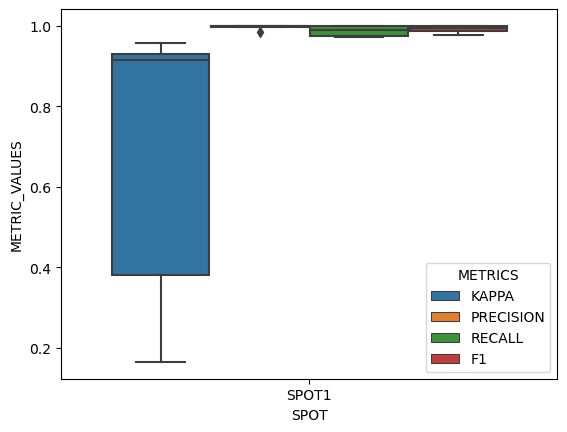

In [11]:
#make plot from dataframe
tiles = ["31TGL"]
spots = ["SPOT1"]
landsats = ["LT05"]
df_file = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/snow_code/performances/output/timeserie_31TGL.pkl"
df = pd.read_pickle(df_file)
print(df)
df_metrics = df[["SPOT","KAPPA",'PRECISION', 'RECALL','F1']].melt(id_vars=["SPOT"], 
                  var_name="METRICS", 
                  value_name="METRIC_VALUES")  



sn.boxplot(data=df_metrics,x="SPOT",y="METRIC_VALUES",hue="METRICS")


In [ ]:
# 